GSE213740 study used 25 % threshold and remove cells that have a higher than this threshold mitochodrial gene percentage.
They self-annotated these genes.
They used 0.8 resolution to cluster cells.
These cells were obtained from the aortic tissue.

This study used the ascending aortic wall samples.

In the quality control analysis, low-quality cells with >25% reads mapped to the mitochondria or cells with <700 or >15,000 UMI counts were removed.

In [2]:
import celltypist
from celltypist import models

In [3]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import os
import scvi
import numpy as np
import seaborn as scs
import os

# Data retrieval
import pooch

In [97]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [98]:
import re

pattern = r'^(.*?)(barcodes|features|matrix)'

samples = set()

for filename in os.listdir('GSE213740_RAW'):
    match = re.search(pattern, filename)
    if match:
        result = match.group(1)
        samples.add(result)
samples

{'GSM6593315_AD_replicate_1_',
 'GSM6593316_AD_replicate_2_',
 'GSM6593317_AD_replicate_3_',
 'GSM6593318_AD_replicate_4_',
 'GSM6593319_AD_replicate_5_',
 'GSM6593320_AD_replicate_6_',
 'GSM6593321_Normal_replicate_1_',
 'GSM6593322_Normal_replicate_2_',
 'GSM6593323_Normal_replicate_3_'}

In [99]:
def pp(sample_prefix):
    path = "GSE213740_RAW"
    adata = sc.read_10x_mtx(path, prefix = sample_prefix)
    adata.var_names_make_unique()
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
    adata = sc.read_10x_mtx(path, prefix = sample_prefix)
    adata.obs['Sample'] = sample_prefix.split('_')[0] 
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 25]
    adata = adata[adata.obs.pct_counts_ribo < 15]

    return adata

In [100]:
out = []
for file in samples:
    out.append(pp(file))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [08:30<00:00,  1.27s/it, v_num=1, train_loss_step=548, train_loss_epoch=613]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [08:30<00:00,  1.28s/it, v_num=1, train_loss_step=548, train_loss_epoch=613]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 261/400:  65%|██████▌   | 261/400 [02:36<01:23,  1.67it/s, v_num=1, train_loss_step=0.41, train_loss_epoch=0.329] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.311. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [07:47<00:00,  1.18s/it, v_num=1, train_loss_step=778, train_loss_epoch=796]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [07:47<00:00,  1.17s/it, v_num=1, train_loss_step=778, train_loss_epoch=796]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 278/400:  70%|██████▉   | 278/400 [02:25<01:04,  1.90it/s, v_num=1, train_loss_step=0.416, train_loss_epoch=0.329]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.296. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [14:57<00:00,  2.25s/it, v_num=1, train_loss_step=645, train_loss_epoch=660]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [14:57<00:00,  2.24s/it, v_num=1, train_loss_step=645, train_loss_epoch=660]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 229/400:  57%|█████▋    | 229/400 [03:23<02:31,  1.13it/s, v_num=1, train_loss_step=0.412, train_loss_epoch=0.281]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.252. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [08:21<00:00,  1.26s/it, v_num=1, train_loss_step=600, train_loss_epoch=779]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [08:21<00:00,  1.25s/it, v_num=1, train_loss_step=600, train_loss_epoch=779]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 244/400:  61%|██████    | 244/400 [02:15<01:26,  1.80it/s, v_num=1, train_loss_step=0.344, train_loss_epoch=0.359] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.360. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [14:32<00:00,  2.18s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.04e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [14:32<00:00,  2.18s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.04e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 189/400:  47%|████▋     | 189/400 [02:15<02:31,  1.39it/s, v_num=1, train_loss_step=0.474, train_loss_epoch=0.336]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.322. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [08:18<00:00,  1.23s/it, v_num=1, train_loss_step=528, train_loss_epoch=901]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [08:18<00:00,  1.25s/it, v_num=1, train_loss_step=528, train_loss_epoch=901]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 268/400:  67%|██████▋   | 268/400 [02:21<01:09,  1.90it/s, v_num=1, train_loss_step=0.283, train_loss_epoch=0.329] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.338. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [08:03<00:00,  1.21s/it, v_num=1, train_loss_step=636, train_loss_epoch=682]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [08:03<00:00,  1.21s/it, v_num=1, train_loss_step=636, train_loss_epoch=682]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 356/400:  89%|████████▉ | 356/400 [03:20<00:24,  1.77it/s, v_num=1, train_loss_step=0.43, train_loss_epoch=0.325] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.298. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [09:28<00:00,  1.43s/it, v_num=1, train_loss_step=760, train_loss_epoch=666]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [09:28<00:00,  1.42s/it, v_num=1, train_loss_step=760, train_loss_epoch=666]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 186/400:  46%|████▋     | 186/400 [01:56<02:13,  1.60it/s, v_num=1, train_loss_step=0.297, train_loss_epoch=0.36] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.351. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 390/390: 100%|██████████| 390/390 [20:54<00:00,  3.19s/it, v_num=1, train_loss_step=645, train_loss_epoch=673]

`Trainer.fit` stopped: `max_epochs=390` reached.


Epoch 390/390: 100%|██████████| 390/390 [20:54<00:00,  3.22s/it, v_num=1, train_loss_step=645, train_loss_epoch=673]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 174/400:  44%|████▎     | 174/400 [03:15<04:13,  1.12s/it, v_num=1, train_loss_step=0.146, train_loss_epoch=0.257]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.236. Signaling Trainer to stop.


In [101]:
adata = sc.concat(out)

In [102]:
from scipy.sparse import csr_matrix

In [103]:
adata.X = csr_matrix(adata.X)

In [104]:
adata.write_h5ad('combined.h5ad')

... storing 'Sample' as categorical


### Annotating the combined dataset

In [105]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

In [106]:
adata = sc.read_h5ad('combined.h5ad')
adata

AnnData object with n_obs × n_vars = 67779 × 22954
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [108]:
sc.pp.filter_genes(adata, min_cells = 100)

In [109]:
adata.layers['counts'] = adata.X.copy()

In [110]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [111]:
adata.obs.head()

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AAACCCAAGGGACAGG-1,GSM6593319,False,1601,1600,3793.0,0.0,0.0,427.0,11.257580
AAACCCACAAACAGGC-1,GSM6593319,False,3720,3720,10983.0,0.0,0.0,858.0,7.812073
AAACCCACATATGAAG-1,GSM6593319,False,1105,1104,2263.0,0.0,0.0,226.0,9.986743
AAACCCAGTCCGGATC-1,GSM6593319,False,1420,1420,3679.0,0.0,0.0,140.0,3.805382
AAACCCAGTGGAACAC-1,GSM6593319,False,318,318,1407.0,0.0,0.0,86.0,6.112296


In [112]:
adata

AnnData object with n_obs × n_vars = 67779 × 20641
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [113]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [114]:
model = scvi.model.SCVI(adata)

In [115]:
model.train() #may take a while without GPU

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 118/118: 100%|██████████| 118/118 [31:02<00:00, 15.88s/it, v_num=1, train_loss_step=5.87e+3, train_loss_epoch=6.47e+3]

`Trainer.fit` stopped: `max_epochs=118` reached.


Epoch 118/118: 100%|██████████| 118/118 [31:02<00:00, 15.79s/it, v_num=1, train_loss_step=5.87e+3, train_loss_epoch=6.47e+3]


In [116]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [117]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [118]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [119]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.8)

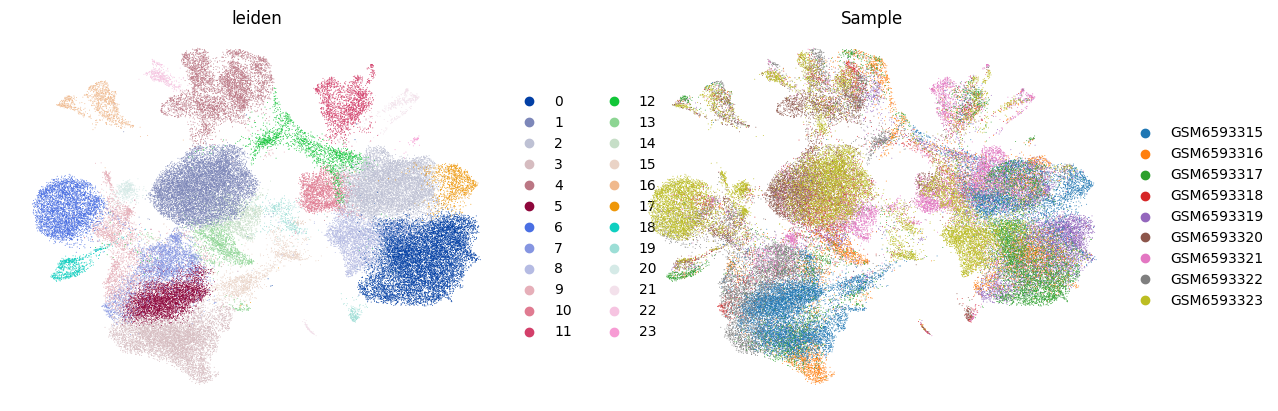

In [120]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

In [121]:
adata.write_h5ad('integrated.h5ad')